#### **Import Libraries**

In [59]:
from typing import Tuple, Sequence
import jax 
import jax.numpy as jnp
from jax import Array
import flax.linen as nn 
from functools import partial 
from tqdm import tqdm 
import optax 
import seaborn as sns
import math 
from einops import rearrange, repeat
from diffrax import diffeqsolve, ODETerm, Dopri5
from tqdm import tqdm 
from rfp import MLP, Model, ModelParams
from rfp.losses import Supervised_Loss, mse, Cluster_Loss
from rfp.train import Trainer

#### **Path**

In [60]:
figure_folders = './../../../rfp_paper/figures/'

#### **Set Up Plotting**

In [61]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/rfp/styles/Newsreader/static/Newsreader_14pt/Newsreader_14pt-ExtraBoldItalic.ttf


#### **Data Hyperparameters**

In [62]:
n = 100                    
init_key = jax.random.PRNGKey(0)
nodes = 128
inner_lr = 1e-3
lr = 1e-3
epochs = 5000 
inner_epochs = 3
simulations = 100
reg_value = 0.9
overlap = 0.5

#### **Sample Data**

In [63]:
def sample1(key, n, overlap):
    xs = jax.random.uniform(key, minval=-overlap, maxval=2*math.pi, shape=(n,1))
    outcomes = jnp.sin(2*xs)
    return xs, outcomes

def sample2(key, n, overlap):
    xs = jax.random.uniform(key, minval=-2*math.pi, maxval=overlap, shape=(n,1))
    outcomes = jnp.cos(xs)
    return xs, outcomes


In [64]:
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(mse, model.fwd_pass) #*** I am not sure this is correct***
standard_yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)


inner_yuri = Trainer(supervised_loss, optax.sgd(learning_rate=inner_lr), inner_epochs)
cluster_loss_train = Cluster_Loss(inner_yuri, reg_value)
cluster_yuri = Trainer(cluster_loss_train,   optax.sgd(learning_rate=lr, momentum=0.9), epochs)

Final Activation Function: <function <lambda> at 0x7f04c4720280>


In [65]:
def get_data_params(key, n, overlap):
    k1, k2, k3 = jax.random.split(key, 3)
    
    xs1, ys1 = sample1(k1, n, overlap)
    xs2, ys2 = sample2(k2, n, overlap)
    
    batch_inputs, batch_outcomes  = jnp.stack((xs1, xs2), axis=0), jnp.stack((ys1, ys2), axis=0)
    inputs = rearrange(batch_inputs, 'a b c -> (a b) c')
    outcomes = rearrange(batch_outcomes, 'a b c -> (a b) c')

    inputs_standardized = jax.nn.standardize(inputs, axis=0)
    batch_inputs_standarized = rearrange(inputs_standardized, '(a b) c -> a b c', a=2)


    params = ModelParams.init_fn(k3, mlp, 1)

    return {'inputs_standarized': inputs_standardized,
            'batch_inputs_standarized': batch_inputs_standarized,
            'outcomes': outcomes,
            'batch_outcomes': batch_outcomes, 
            'params': params, 
            'batch_inputs':batch_inputs,
            'inputs': inputs,
            'outcomes': outcomes
            }


In [66]:
def cluster_simulate(key, n, overlap):
    setup = get_data_params(key, n, overlap)
    opt_params, training_loss = cluster_yuri.train(setup['params'],
                                                    setup['batch_inputs_standarized'],
                                                    setup['batch_outcomes'],
                                                    mask=jnp.ones_like(setup['batch_outcomes']))
    return  setup, opt_params, training_loss

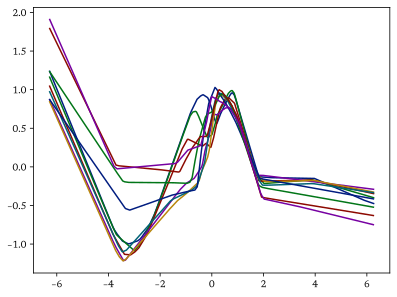

In [67]:
for i in jnp.linspace(0, math.pi, 10):
    setup, params, losses = cluster_simulate(init_key, n, i)
    yhat = model.fwd_pass(params, setup['inputs_standarized'])
    idx = jnp.argsort(setup['inputs'].reshape(-1,))
    plt.plot(setup['inputs'][idx], yhat[idx], label=i)
plt.show()

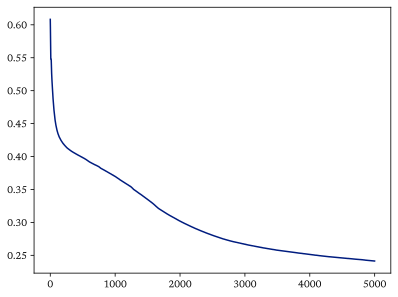

In [68]:
plt.plot(losses)
plt.show()